**First clone the github repository**

In [1]:
#%cd /content
#! git clone https://github.com/Tikquuss/lwd
#%cd lwd/scripts

# **Set-up** 
*Once this section is configured, you can comment (optionally) the previous cell and run everything at once (Runtime -> Run all).*

Uncomment the line corresponding to your function, and choose the value xxx accordingly:
* For Black&Scholes, INPUT_DIM must remain at 1.
* For Gaussian basket options, INPUT_DIM can take any integer value greater than or equal to 1.


In [2]:
f_name = "Black&Scholes"
#f_name = "Gaussian basket options" # vary INPUT_DIM : 1,...,7,..., 20,...

INPUT_DIM = 1

In [3]:
try:
    %tensorflow_version 1.x
    %matplotlib inline
except Exception:
    pass

import torch.nn.functional as F
import torch
import numpy as np
import matplotlib.pyplot as plt

import random

from utils import plot_stat, MLP, Siren, train, test
from twin_net_tf import graph, get_diffML_data_loader, BlackScholes, Bachelier, test as twin_net_tf_test 
from twin_net_tf_siren import test as twin_net_tf_test_siren

TensorFlow 1.x selected.
1.15.2
False


1.15.2
False


In [4]:
# Global
max_epoch = 2
batch_size = 1
nTrain = 25
nTest = 25
learning_rate = 3e-5
improving_limit = float("inf") # no limit
HIDDEN_DIM = 20
N_HIDDEN = 2
OUTPUT_DIM = 1

# MLP
activation_function = F.softplus
deriv_activation_function = torch.sigmoid # for twin_net_pytorch
mlp_model_kwargs = {"in_features" : INPUT_DIM, # depends on the function
                    "hidden_features" : HIDDEN_DIM, 
                    "hidden_layers" : N_HIDDEN, 
                    "out_features": OUTPUT_DIM, 
                    "activation_function" : activation_function, 
                    "deriv_activation_function" : deriv_activation_function,
                   }

generator_kwargs = {"hidden_units" : HIDDEN_DIM, 
                    "hidden_layers" : N_HIDDEN}

# hyperparameters in the different loss functions to express a tradeoff between y loss and dy loss
loss_config = {'alpha': 1, "beta" : 1} 

# twin_net
train_seed, test_seed = 0, 0
learning_rate_schedule = [(0.0, 1.0e-8), (0.2, 0.1), (0.6, 0.01), (0.9, 1.0e-6), (1.0, 1.0e-8)]

# Siren
first_omega_0 = 30.
hidden_omega_0 = 30.
outermost_linear = True

siren_model_kwargs = {"in_features" : INPUT_DIM, 
                      "hidden_features" : HIDDEN_DIM, 
                      "hidden_layers" : N_HIDDEN, 
                      "out_features": OUTPUT_DIM, 
                      "outermost_linear" : outermost_linear, 
                      "first_omega_0" : first_omega_0, 
                      "hidden_omega_0" : hidden_omega_0}

# **To avoid repeating the same code too much**

In [5]:
def run_train(name, generator, with_derivative, model_class, model_kwargs, normalize, learning_rate_schedule = None):
    
    global nTrain, nTest, train_seed, test_seed, batch_size, learning_rate
    global max_epoch, improving_limit
    global loss_config 

    train_dataloader, test_dataloader, xAxis, vegas, config = get_diffML_data_loader(
        generator = generator, 
        nTrain = nTrain, nTest = nTest, 
        train_seed = train_seed, test_seed = test_seed, batch_size = batch_size, with_derivative = with_derivative,
        normalize = normalize
    )
    
    config["learning_rate_schedule"] = learning_rate_schedule
    config.update(loss_config)
     
    model = model_class(**model_kwargs)
    criterion = torch.nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

    model, stats, best_loss = train(name, model, train_dataloader, optimizer, criterion, config, 
                                    with_derivative, max_epoch = max_epoch, improving_limit = improving_limit)
    
    plot_stat(stats, with_derivative = with_derivative)

    (test_loss, r_y, r_dydx), (x_list, y_list, dydx_list, y_pred_list, dydx_pred_list) = test(
        name, model, test_dataloader, criterion, config, with_derivative
    )
    
    xy = [(x[0], y[0]) for x, y in zip(x_list, y_list)]
    xy_pred = [(x[0], y[0]) for x, y in zip(x_list, y_pred_list)]
  
    if with_derivative :
        xdydx = [(x[0], y[0]) for x, y in zip(x_list, dydx_list)]
        xdydx_pred = [(x[0], y) for x, y in zip(x_list, dydx_pred_list)]

        fig, (ax1, ax2) = plt.subplots(1, 2, sharex=True, figsize = (15,3))
    else :
        fig, ax1 = plt.subplots(1, 1, sharex=True, figsize = (15,3))

    fig.suptitle('')
    
    ax1.scatter(*zip(*xy), label = "y")
    ax1.scatter(*zip(*xy_pred), label = "ypred")
    ax1.set(xlabel='x', ylabel='y, y_pred')
    ax1.legend()
    if with_derivative :
        ax2.scatter(*zip(*xdydx), label = "dy")
        ax2.scatter(*zip(*xdydx_pred), label = "dy pred")
        ax2.set(xlabel='x', ylabel='dy, dy_pred')
        ax2.legend()
        
    return model, test_loss, stats

def run_diffML_train(name, generator, generator_kwargs, show_graph_per_axis = False, input_dim = None, siren = False):
    global nTrain, nTest, train_seed, test_seed
    global max_epoch
    global first_omega_0, hidden_omega_0, outermost_linear
    
    if siren :
        loss, regressor, dtrain, dtest, dydxTest, values, deltas, xAxis, vegas = twin_net_tf_test_siren(
              generator, [nTrain], 
              nTrain, nTest, 
              trainSeed = train_seed, testSeed = test_seed, weightSeed = 0, 
              deltidx=0,
              generator_kwargs = generator_kwargs,
              epochs = max_epoch,
              first_omega_0 = first_omega_0, 
              hidden_omega_0 = hidden_omega_0, 
              outermost_linear = outermost_linear,
              improving_limit = improving_limit
              ) 
    else :
        loss, regressor, dtrain, dtest, dydxTest, values, deltas, xAxis, vegas = twin_net_tf_test(
              generator, [nTrain], 
              nTrain, nTest, 
              trainSeed = train_seed, testSeed = test_seed, weightSeed = 0, 
              deltidx=0,
              generator_kwargs = generator_kwargs,
              epochs = max_epoch
              )
    #plot_stat(regressor.regressor.stats["normal"], with_derivative = with_derivative)
    #plot_stat(regressor.stats["differential"], with_derivative = with_derivative)

    yTest = dtest[1]
    sizes = [nTrain]
    # show predicitions
    graph(name, values, xAxis, "", "values", yTest, [nTrain], True)
    # show deltas
    graph(name, deltas, xAxis, "", "deltas", dydxTest, [nTrain], True)

    if show_graph_per_axis :
        assert input_dim
        for i in range(input_dim) :
            xAxis  = np.array([[x[i]] for x in dtest[0]])
            # show predicitions
            graph("%s x%d vs y" % (name, (i+1)), values, xAxis, "", "values", yTest, [nTrain], True)
            # show deltas
            graph("%s x%d vs dxdy" % (name, (i+1)), deltas, xAxis, "", "deltas", dydxTest, [nTrain], True)
    return regressor, loss

def global_stat(stats_dic, suptitle = ""):
    #todo
    print(stats_dic)

In [6]:
if f_name == "Black&Scholes" :
    generator = BlackScholes()
    # for twin_net_tf
    graph_name = "Black & Scholes"
elif f_name == "Gaussian basket options" : 
    generator = Bachelier(n = INPUT_DIM)
    # for twin_net_tf
    graph_name = "Bachelier dimension %d" % INPUT_DIM
stats_dic = {}

# **1) Normal Training**

In [7]:
name = "net"
with_derivative = False
key1 = "normal_training"
stats_dic[key1] = {}

## **1.1) with MLP**

In [8]:
model_class = MLP
key2 = "mlp"
stats_dic[key1][key2] = {}

### **1.1.1) normalize = False**

In [9]:
key3 = "no_normalize"
stats_dic[key1][key2][key3] = [None, None]

Epoch 0: train loss: 0.33458205938339236 train loss no scaled: 0.33458205938339236

Epoch 1: train loss: 0.3031326761841774 train loss no scaled: 0.3031326761841774





test loss: 0.2433568260073662 test loss no scaled 0.2433568260073662


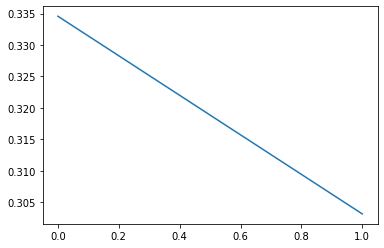

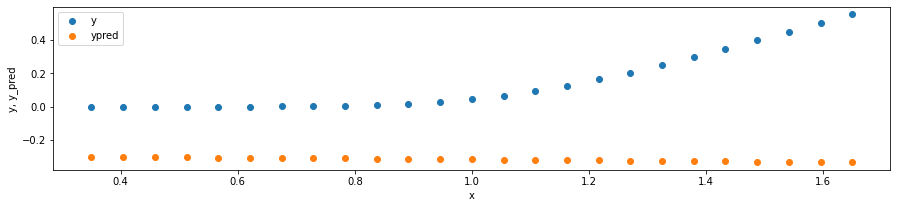

In [10]:
model, test_loss, stats_dic[key1][key2][key3][0] = run_train(
    name = name, 
    generator = generator, 
    with_derivative = with_derivative, 
    model_class = model_class, 
    model_kwargs = mlp_model_kwargs,
    normalize = False, 
    learning_rate_schedule = None)

Epoch 0: train loss: 0.21117836143999738 train loss no scaled: 0.21117836143999738

Epoch 1: train loss: 0.19169505072990434 train loss no scaled: 0.19169505072990434





test loss: 0.1777212790772319 test loss no scaled 0.1777212790772319


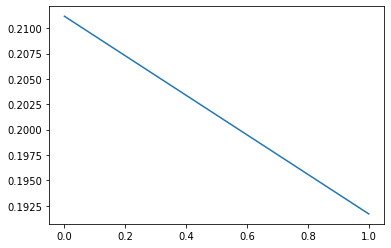

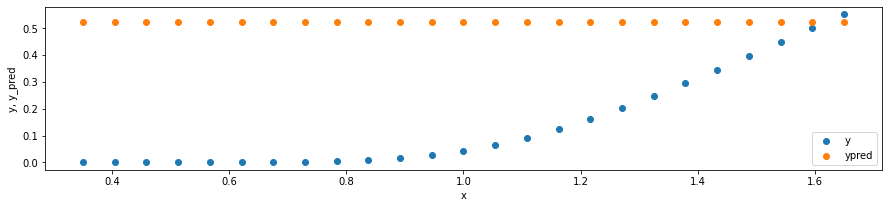

In [11]:
model, test_loss, stats_dic[key1][key2][key3][1] = run_train(
    name = name, 
    generator = generator, 
    with_derivative = with_derivative, 
    model_class = model_class, 
    model_kwargs = mlp_model_kwargs,
    normalize = False, 
    learning_rate_schedule = learning_rate_schedule)

### **1.1.2) normalize = True**

In [12]:
key3 = "normalize"
stats_dic[key1][key2][key3] = [None, None]

Epoch 0: train loss: 1.11059097468853 train loss no scaled: 0.05788183556869626

Epoch 1: train loss: 1.1031827810406685 train loss no scaled: 0.05749573595821857





test loss: 0.7639093809388577 test loss no scaled 0.039813467564526944


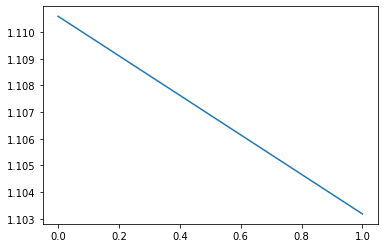

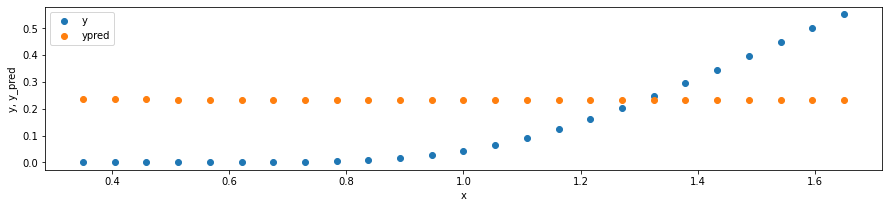

In [13]:
model, test_loss, stats_dic[key1][key2][key3][0] = run_train(
    name = name, 
    generator = generator, 
    with_derivative = with_derivative, 
    model_class = model_class, 
    model_kwargs = mlp_model_kwargs,
    normalize = True, 
    learning_rate_schedule = None)

Epoch 0: train loss: 1.313491124017164 train loss no scaled: 0.06845659372629598

Epoch 1: train loss: 1.2943011300452054 train loss no scaled: 0.06745645064627752





test loss: 0.9994595549393853 test loss no scaled 0.05208988097496331


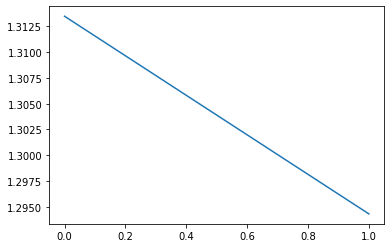

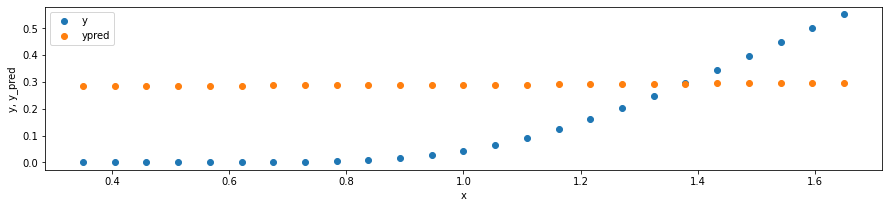

In [14]:
model, test_loss, stats_dic[key1][key2][key3][1] = run_train(
    name = name, 
    generator = generator, 
    with_derivative = with_derivative, 
    model_class = model_class, 
    model_kwargs = mlp_model_kwargs,
    normalize = True, 
    learning_rate_schedule = learning_rate_schedule)

## **1.2) with Siren**

In [15]:
model_class = Siren
key2 = "siren"
stats_dic[key1][key2] = {}


### **1.2.1) normalize = False**

In [16]:
key3 = "no_normalize"
stats_dic[key1][key2][key3] = [None, None]

Epoch 0: train loss: 0.06585207189185895 train loss no scaled: 0.06585207189185895

Epoch 1: train loss: 0.06310642761835879 train loss no scaled: 0.06310642761835879





test loss: 0.039063967352805096 test loss no scaled 0.039063967352805096


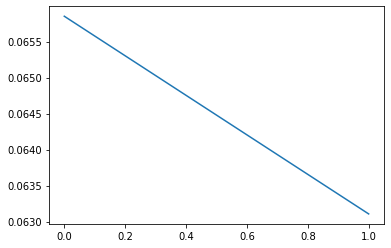

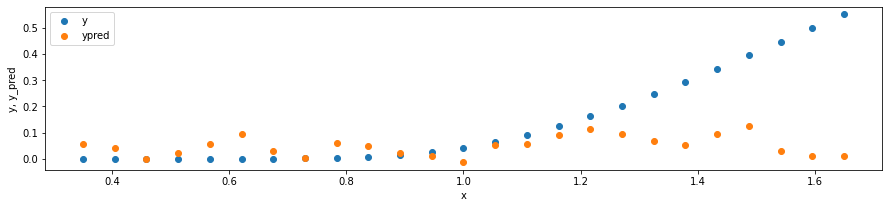

In [17]:
model, test_loss, stats_dic[key1][key2][key3][0] = run_train(
    name = name, 
    generator = generator, 
    with_derivative = with_derivative, 
    model_class = model_class, 
    model_kwargs = siren_model_kwargs,
    normalize = False, 
    learning_rate_schedule = None)

Epoch 0: train loss: 0.0506098364686477 train loss no scaled: 0.0506098364686477

Epoch 1: train loss: 0.047409993122422875 train loss no scaled: 0.047409993122422875





test loss: 0.023647665378211967 test loss no scaled 0.023647665378211967


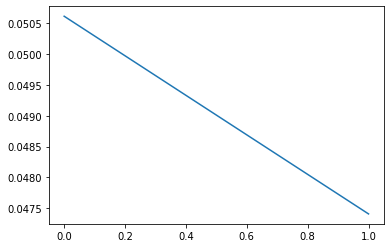

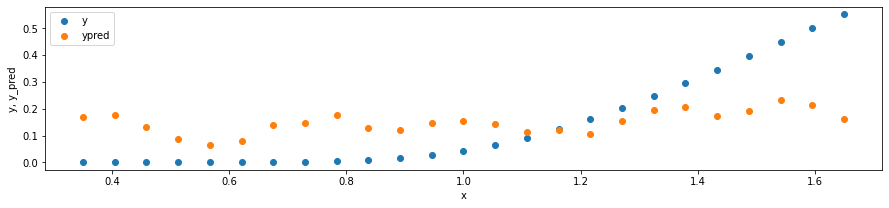

In [18]:
model, test_loss, stats_dic[key1][key2][key3][1] = run_train(
    name = name, 
    generator = generator, 
    with_derivative = with_derivative, 
    model_class = model_class, 
    model_kwargs = siren_model_kwargs,
    normalize = False, 
    learning_rate_schedule = learning_rate_schedule)

### **1.2.2) normalize = True**

In [19]:
key3 = "normalize"
stats_dic[key1][key2][key3] = [None, None]

Epoch 0: train loss: 0.997600126452744 train loss no scaled: 0.05199297339189798

Epoch 1: train loss: 0.9885951699689031 train loss no scaled: 0.05152365324553102





test loss: 0.6201519440719858 test loss no scaled 0.03232110991171794


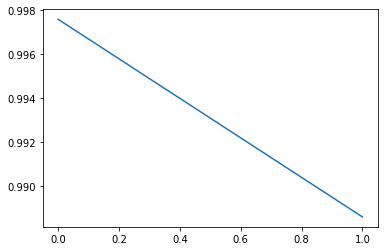

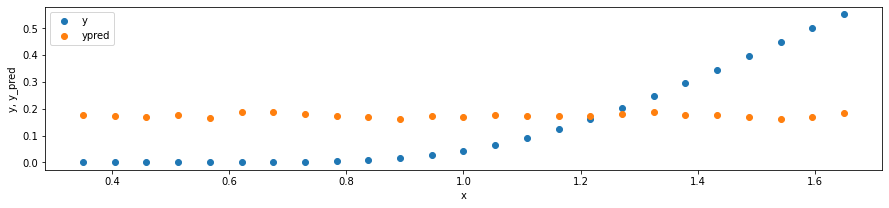

In [20]:
model, test_loss, stats_dic[key1][key2][key3][0] = run_train(
    name = name, 
    generator = generator, 
    with_derivative = with_derivative, 
    model_class = model_class, 
    model_kwargs = siren_model_kwargs,
    normalize = True, 
    learning_rate_schedule = None)

Epoch 0: train loss: 1.0208095971122384 train loss no scaled: 0.0532026050996501

Epoch 1: train loss: 1.0132266207039355 train loss no scaled: 0.052807395001873376





test loss: 0.5921870801245314 test loss no scaled 0.030863635994653294


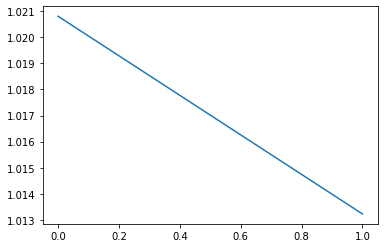

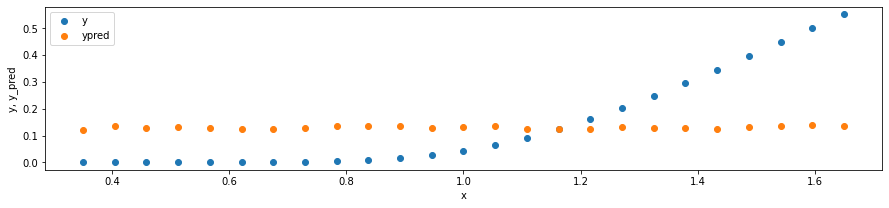

In [21]:
model, test_loss, stats_dic[key1][key2][key3][1] = run_train(
    name = name, 
    generator = generator, 
    with_derivative = with_derivative, 
    model_class = model_class, 
    model_kwargs = siren_model_kwargs,
    normalize = True, 
    learning_rate_schedule = learning_rate_schedule)

# **2) Sobolev Training**

In [22]:
name = "net"
with_derivative = True
key1 = "sobolev_training"
stats_dic[key1] = {}

## **2.1) with MLP**

In [23]:
model_class = MLP
key2 = "mlp"
stats_dic[key1][key2] = {}

### **2.1.1) normalize = False**

In [24]:
key3 = "no_normalize"
stats_dic[key1][key2][key3] = [None, None]

Epoch 0: train loss: 0.5948491236567497, y loss : 0.23572960495948792, dy loss : 0.35911951601970943

train loss no scaled: 0.5948491209791973, y loss  no scaled : 0.23572960495948792, dy loss  no scaled: 0.35911951601970943


Epoch 1: train loss: 0.5736982741951943, y loss : 0.2151367749273777, dy loss : 0.35856149590923453

train loss no scaled: 0.5736982708366123, y loss  no scaled : 0.2151367749273777, dy loss  no scaled: 0.35856149590923453






test loss: 0.5093263144791126, y loss : 0.1685868266224861, dydx loss : 0.3407394936255878

test loss no scaled: 0.5093263202480739, y loss  no scaled : 0.1685868266224861, dydx loss  no scaled: 0.3407394936255878




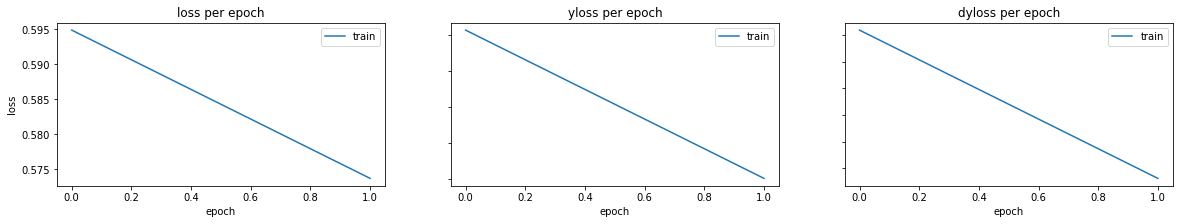

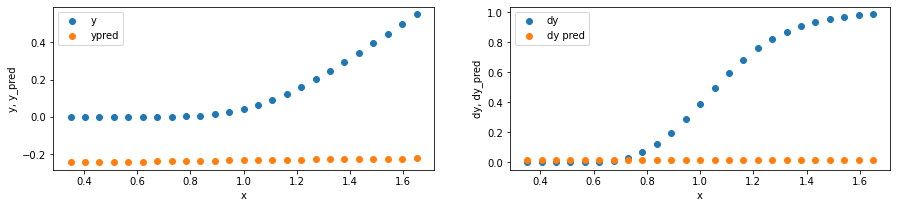

In [25]:
model, test_loss, stats_dic[key1][key2][key3][0] = run_train(
    name = name, 
    generator = generator, 
    with_derivative = with_derivative, 
    model_class = model_class, 
    model_kwargs = mlp_model_kwargs,
    normalize = False, 
    learning_rate_schedule = None)

Epoch 0: train loss: 0.42640052502043546, y loss : 0.0634755763420253, dy loss : 0.362924948023865

train loss no scaled: 0.42640052436589027, y loss  no scaled : 0.0634755763420253, dy loss  no scaled: 0.362924948023865


Epoch 1: train loss: 0.423443308910355, y loss : 0.06072650665684705, dy loss : 0.3627168050361797

train loss no scaled: 0.42344331169302674, y loss  no scaled : 0.06072650665684705, dy loss  no scaled: 0.3627168050361797






test loss: 0.38046747701242567, y loss : 0.03509292746799474, dydx loss : 0.34537455195822303

test loss no scaled: 0.3804674794262178, y loss  no scaled : 0.03509292746799474, dydx loss  no scaled: 0.34537455195822303




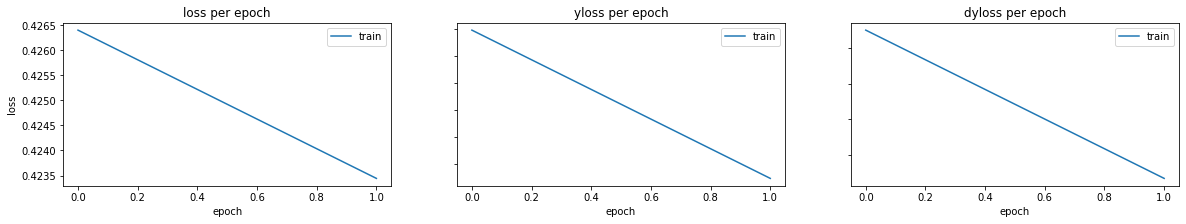

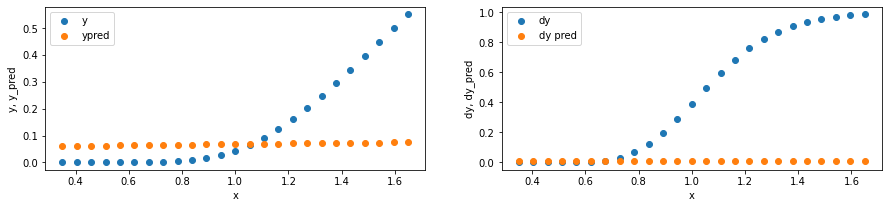

In [26]:
model, test_loss, stats_dic[key1][key2][key3][1] = run_train(
    name = name, 
    generator = generator, 
    with_derivative = with_derivative, 
    model_class = model_class, 
    model_kwargs = mlp_model_kwargs,
    normalize = False, 
    learning_rate_schedule = learning_rate_schedule)

### **2.1.2) normalize = True**

In [27]:
key3 = "normalize"
stats_dic[key1][key2][key3] = [None, None]

Epoch 0: train loss: 2.1639530199766157, y loss : 1.1350161436060444, dy loss : 1.0289368535409449

train loss no scaled: 1.0880916815161619, y loss  no scaled : 0.0591548279752169, dy loss  no scaled: 1.0289368535409449


Epoch 1: train loss: 2.15448722243309, y loss : 1.126958452553954, dy loss : 1.0275287562487938

train loss no scaled: 1.0862636327686415, y loss  no scaled : 0.0587348765198476, dy loss  no scaled: 1.0275287562487938






test loss: 1.045667337179184, y loss : 0.6627060536621139, dydx loss : 0.38296129571663184

test loss no scaled: 0.41750024274439057, y loss  no scaled : 0.0345389470277587, dydx loss  no scaled: 0.38296129571663184




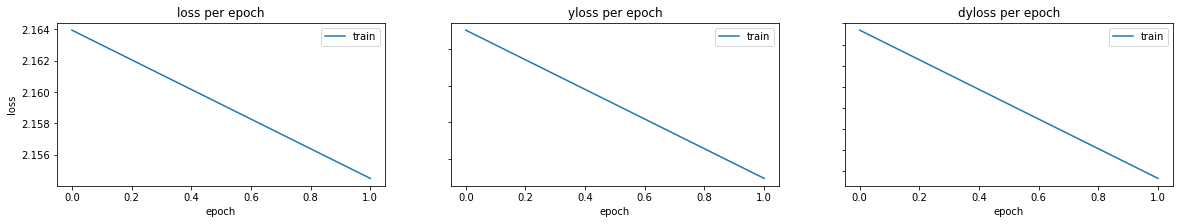

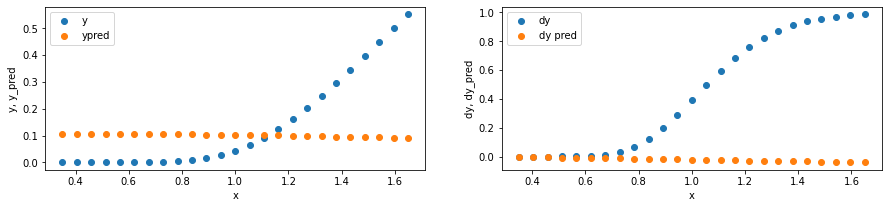

In [28]:
model, test_loss, stats_dic[key1][key2][key3][0] = run_train(
    name = name, 
    generator = generator, 
    with_derivative = with_derivative, 
    model_class = model_class, 
    model_kwargs = mlp_model_kwargs,
    normalize = True, 
    learning_rate_schedule = None)

Epoch 0: train loss: 2.441863767253235, y loss : 1.4933155103994067, dy loss : 0.9485482712695376

train loss no scaled: 1.0263769656211663, y loss  no scaled : 0.07782869435162866, dy loss  no scaled: 0.9485482712695376


Epoch 1: train loss: 2.4092245969735084, y loss : 1.4623172552555115, dy loss : 0.9469073089724407

train loss no scaled: 1.023120430980589, y loss  no scaled : 0.07621312200814828, dy loss  no scaled: 0.9469073089724407






test loss: 1.2713087885675487, y loss : 0.9379598451755009, dydx loss : 0.3333489283526433

test loss no scaled: 0.38223356660739227, y loss  no scaled : 0.04888463825474901, dydx loss  no scaled: 0.3333489283526433




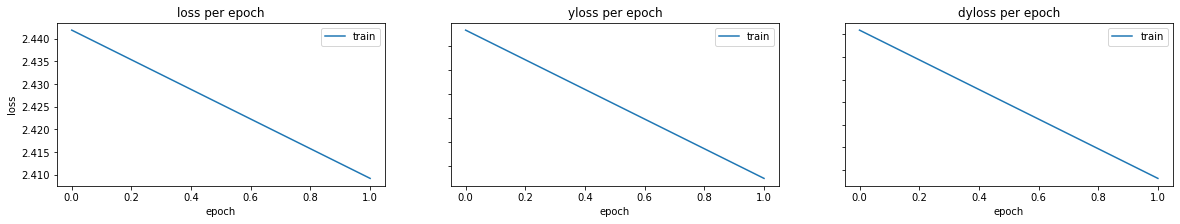

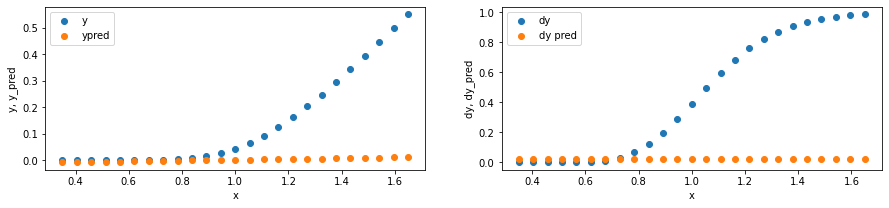

In [29]:
model, test_loss, stats_dic[key1][key2][key3][1] = run_train(
    name = name, 
    generator = generator, 
    with_derivative = with_derivative, 
    model_class = model_class, 
    model_kwargs = mlp_model_kwargs,
    normalize = True, 
    learning_rate_schedule = learning_rate_schedule)

## **2.2) with Siren**

In [30]:
model_class = Siren
key2 = "siren"
stats_dic[key1][key2] = {}

### **2.2.1) normalize = False**

In [31]:
key3 = "no_normalize"
stats_dic[key1][key2][key3] = [None, None]

Epoch 0: train loss: 0.5235981394629925, y loss : 0.06159459103176232, dy loss : 0.4620035561453551

train loss no scaled: 0.5235981471771174, y loss  no scaled : 0.06159459103176232, dy loss  no scaled: 0.4620035561453551


Epoch 1: train loss: 0.506723560988903, y loss : 0.05860656756809703, dy loss : 0.44811699356418105

train loss no scaled: 0.5067235611322781, y loss  no scaled : 0.05860656756809703, dy loss  no scaled: 0.44811699356418105






test loss: 0.49616427744738756, y loss : 0.03054715288794114, dydx loss : 0.4656171268154867

test loss no scaled: 0.49616427970342786, y loss  no scaled : 0.03054715288794114, dydx loss  no scaled: 0.4656171268154867




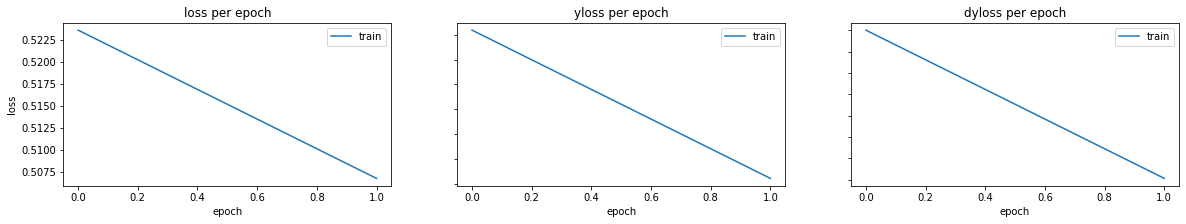

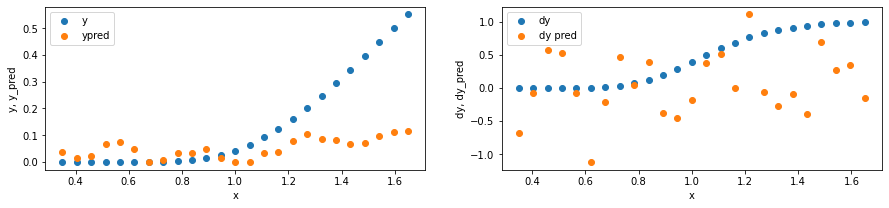

In [32]:
model, test_loss, stats_dic[key1][key2][key3][0] = run_train(
    name = name, 
    generator = generator, 
    with_derivative = with_derivative, 
    model_class = model_class, 
    model_kwargs = siren_model_kwargs,
    normalize = False, 
    learning_rate_schedule = None)

Epoch 0: train loss: 0.47036916693672537, y loss : 0.05798899123474257, dy loss : 0.4123801785847172

train loss no scaled: 0.47036916981945975, y loss  no scaled : 0.05798899123474257, dy loss  no scaled: 0.4123801785847172


Epoch 1: train loss: 0.48544491155073044, y loss : 0.05585878431389574, dy loss : 0.4295861315267905

train loss no scaled: 0.4854449158406862, y loss  no scaled : 0.05585878431389574, dy loss  no scaled: 0.4295861315267905






test loss: 0.6265373034775257, y loss : 0.03145142092769675, dydx loss : 0.5950858907401562

test loss no scaled: 0.6265373116678529, y loss  no scaled : 0.03145142092769675, dydx loss  no scaled: 0.5950858907401562




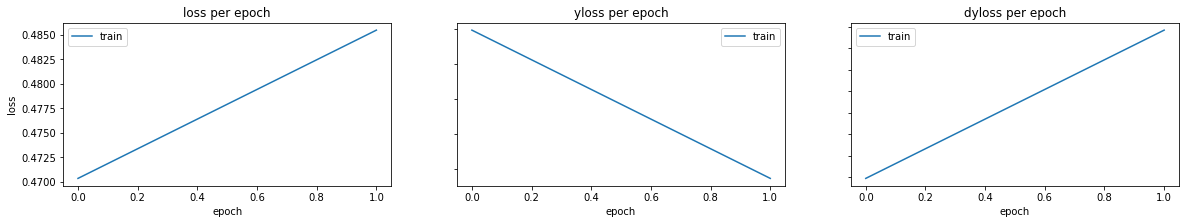

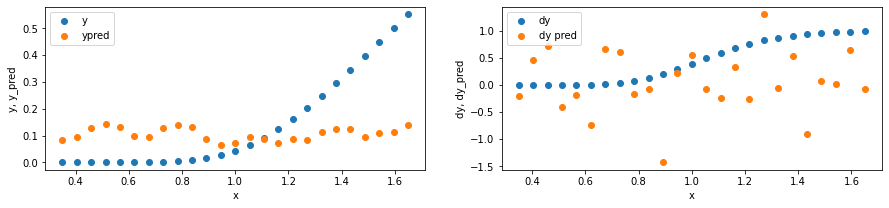

In [33]:
model, test_loss, stats_dic[key1][key2][key3][1] = run_train(
    name = name, 
    generator = generator, 
    with_derivative = with_derivative, 
    model_class = model_class, 
    model_kwargs = siren_model_kwargs,
    normalize = False, 
    learning_rate_schedule = learning_rate_schedule)

### **2.2.2) normalize = True**

In [34]:
key3 = "normalize"
stats_dic[key1][key2][key3] = [None, None]

Epoch 0: train loss: 2.3268758696317673, y loss : 1.0145894742768724, dy loss : 1.31228642042086

train loss no scaled: 1.3651648458282943, y loss  no scaled : 0.052878425407434405, dy loss  no scaled: 1.31228642042086


Epoch 1: train loss: 2.2412646198272705, y loss : 1.0039606742106844, dy loss : 1.2373039464652538

train loss no scaled: 1.2896284206452218, y loss  no scaled : 0.05232447417996809, dy loss  no scaled: 1.2373039464652538






test loss: 1.5787050026655196, y loss : 0.5914304490759968, dydx loss : 0.9872745582349944

test loss no scaled: 1.0180987590084898, y loss  no scaled : 0.03082420077349525, dydx loss  no scaled: 0.9872745582349944




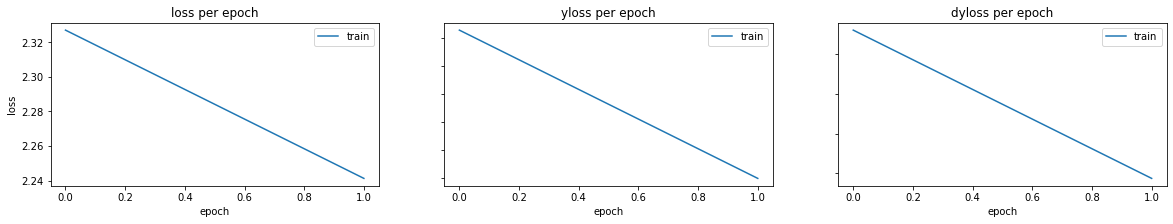

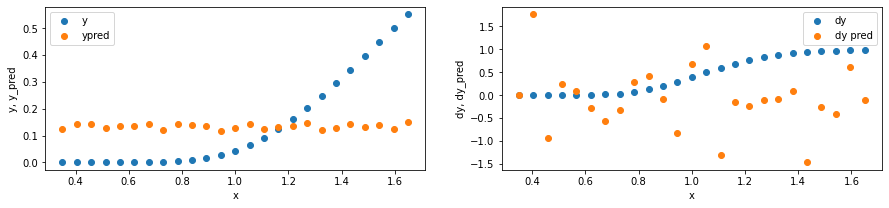

In [35]:
model, test_loss, stats_dic[key1][key2][key3][0] = run_train(
    name = name, 
    generator = generator, 
    with_derivative = with_derivative, 
    model_class = model_class, 
    model_kwargs = siren_model_kwargs,
    normalize = True, 
    learning_rate_schedule = None)

Epoch 0: train loss: 2.1604383111000063, y loss : 1.0401074685156346, dy loss : 1.1203308581840248

train loss no scaled: 1.1745392304845155, y loss  no scaled : 0.054208372300490734, dy loss  no scaled: 1.1203308581840248


Epoch 1: train loss: 2.147104332447052, y loss : 1.0329866515100001, dy loss : 1.1141177116654284

train loss no scaled: 1.1679549608233786, y loss  no scaled : 0.05383724915795028, dy loss  no scaled: 1.1141177116654284






test loss: 1.3203056204319, y loss : 0.691863713990897, dydx loss : 0.6284419211000204

test loss no scaled: 0.6645005075531663, y loss  no scaled : 0.03605858645314584, dydx loss  no scaled: 0.6284419211000204




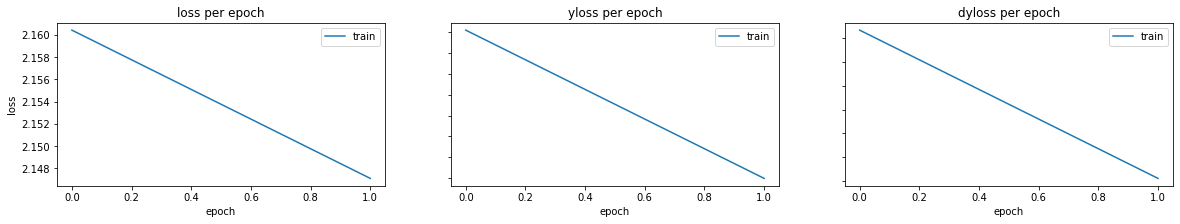

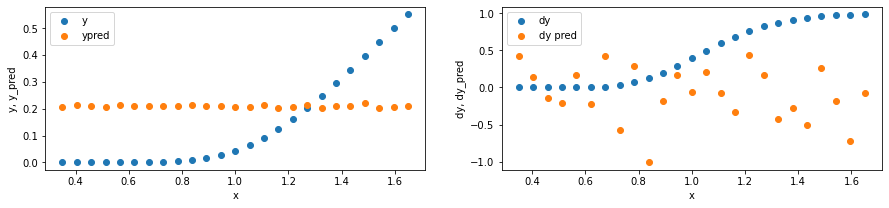

In [36]:
model, test_loss, stats_dic[key1][key2][key3][1] = run_train(
    name = name, 
    generator = generator, 
    with_derivative = with_derivative, 
    model_class = model_class, 
    model_kwargs = siren_model_kwargs,
    normalize = True, 
    learning_rate_schedule = learning_rate_schedule)

# **3) twin_net tensorflow**

In [37]:
key1 = "twin_net_tf"
stats_dic[key1] = {}

## **3.1) with MLP**

In [38]:
key2 = "mlp"
stats_dic[key1][key2] = {}

simulating training, valid and test sets
done
initializing neural appropximator
done

size 25


Epoch 0: y loss : 1.2048544883728027, dy loss : 1.2723464965820312
Epoch 1: y loss : 1.4448930025100708, dy loss : 1.2247337102890015

test y loss : 0.05021027475595474, test dy loss : 0.4784231185913086


Epoch 0: y loss : 1.2048544883728027, dy loss : 1.2723464965820312
Epoch 1: y loss : 1.4437549114227295, dy loss : 1.2242064476013184

test y loss : 0.05018886551260948, test dy loss : 0.47835350036621094


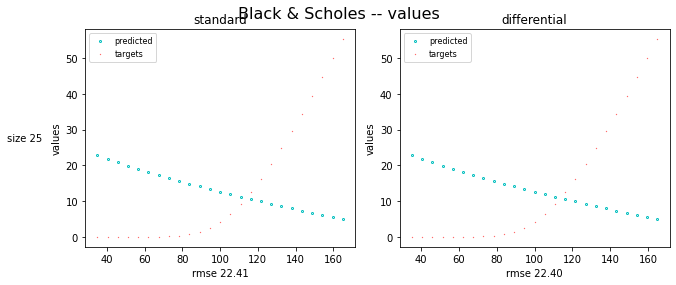

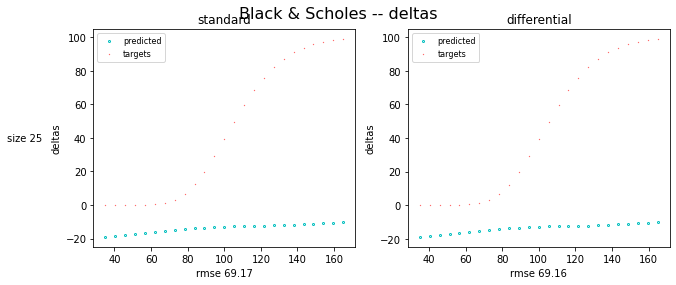

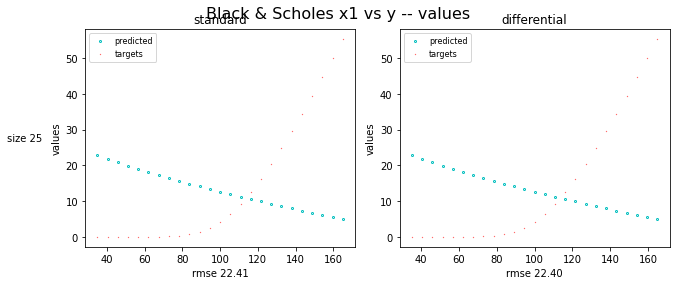

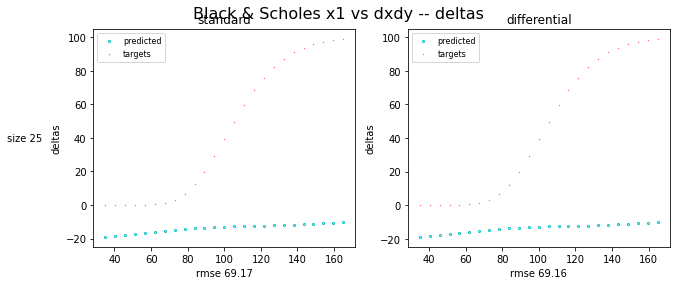

In [39]:
model, loss = run_diffML_train(
              name = graph_name, 
              generator = generator, 
              generator_kwargs = generator_kwargs ,
              show_graph_per_axis = True, 
              input_dim = INPUT_DIM
              )
stats_dic[key1][key2]['normal'] = model.stats["normal"]
stats_dic[key1][key2]['differential'] = model.stats["differential"]

## **3.2) with Siren**

In [40]:
key2 = "siren"
stats_dic[key1][key2] = {}

simulating training, valid and test sets
done
initializing neural appropximator
done

size 25


Epoch 0: y loss : 1.1208713054656982, dy loss : 127.70821380615234
Epoch 1: y loss : 1.5107638835906982, dy loss : 6026.42236328125

test y loss : 0.3193061053752899, test dy loss : 9925.6591796875


Epoch 0: y loss : 1.1208715438842773, dy loss : 127.70832061767578
Epoch 1: y loss : 0.9979817271232605, dy loss : 9690.5576171875

test y loss : 0.40318581461906433, test dy loss : 8087.625


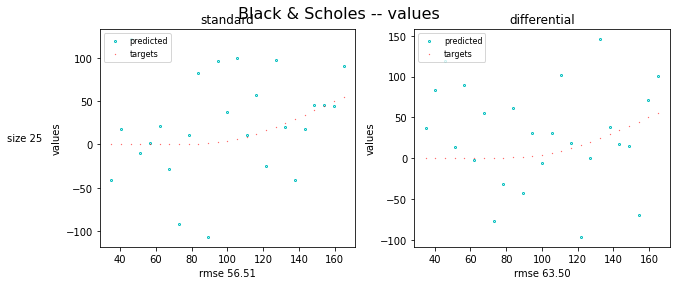

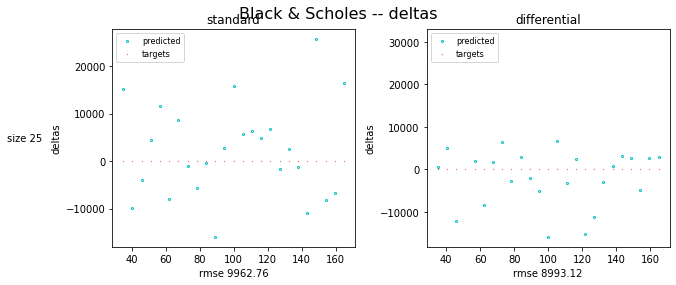

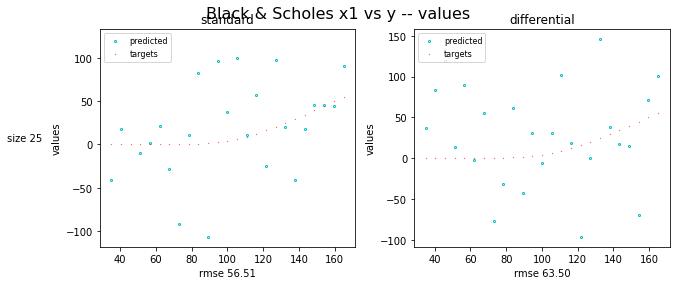

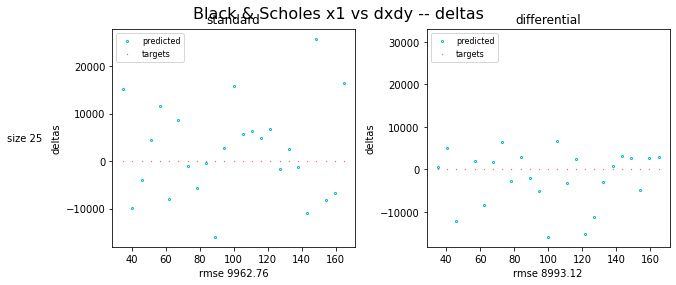

In [41]:
model, loss = run_diffML_train(
              name = graph_name, 
              generator = generator, 
              generator_kwargs = generator_kwargs ,
              show_graph_per_axis = True, 
              input_dim = INPUT_DIM,
              siren = True # siren
              )
stats_dic[key1][key2]['normal'] = model.stats["normal"]
stats_dic[key1][key2]['differential'] = model.stats["differential"]

# **4) twin_net pytorch**

In [42]:
name = "twin_net"
with_derivative = True
key1 = "twin_net_pytorch"
stats_dic[key1] = {}

## **4.1) with MLP**

In [43]:
model_class = MLP
key2 = "mlp"
stats_dic[key1][key2] = {}

### **4.1.1) normalize = False**

In [44]:
key3 = "no_normalize"
stats_dic[key1][key2][key3] = [None, None]

Epoch 0: train loss: 0.4759749350324273, y loss : 0.10471871891990304, dy loss : 0.3712562167769272

train loss no scaled: 0.47597493569683025, y loss  no scaled : 0.10471871891990304, dy loss  no scaled: 0.3712562167769272


Epoch 1: train loss: 0.46766128864139317, y loss : 0.09636322492267936, dy loss : 0.37129806596680565

train loss no scaled: 0.467661290889485, y loss  no scaled : 0.09636322492267936, dy loss  no scaled: 0.37129806596680565






test loss: 0.4173990260856226, y loss : 0.06282854062039406, dydx loss : 0.3545704802276964

test loss no scaled: 0.41739902084809044, y loss  no scaled : 0.06282854062039406, dydx loss  no scaled: 0.3545704802276964




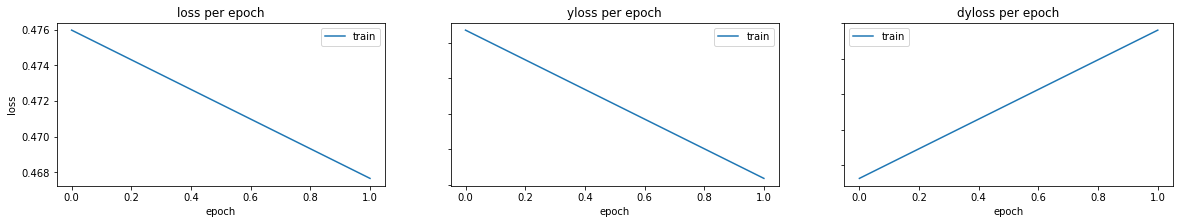

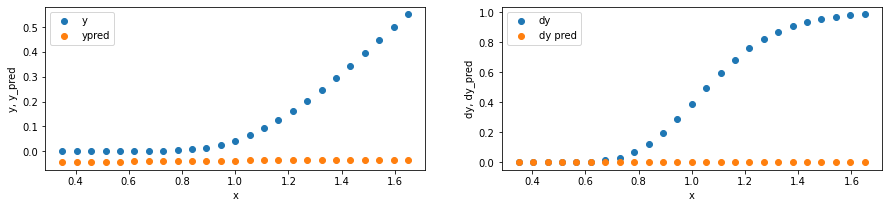

In [45]:
model, test_loss, stats_dic[key1][key2][key3][0] = run_train(
    name = name, 
    generator = generator, 
    with_derivative = with_derivative, 
    model_class = model_class, 
    model_kwargs = mlp_model_kwargs,
    normalize = False, 
    learning_rate_schedule = None)

Epoch 0: train loss: 0.6773254251480103, y loss : 0.30834583975374696, dy loss : 0.36897957944929466

train loss no scaled: 0.6773254192030416, y loss  no scaled : 0.30834583975374696, dy loss  no scaled: 0.36897957944929466


Epoch 1: train loss: 0.650340656042099, y loss : 0.2811252241767943, dy loss : 0.36921541916678896

train loss no scaled: 0.6503406433435832, y loss  no scaled : 0.2811252241767943, dy loss  no scaled: 0.36921541916678896






test loss: 0.6204350364208221, y loss : 0.267686704043299, dydx loss : 0.35274833484671037

test loss no scaled: 0.6204350388900093, y loss  no scaled : 0.267686704043299, dydx loss  no scaled: 0.35274833484671037




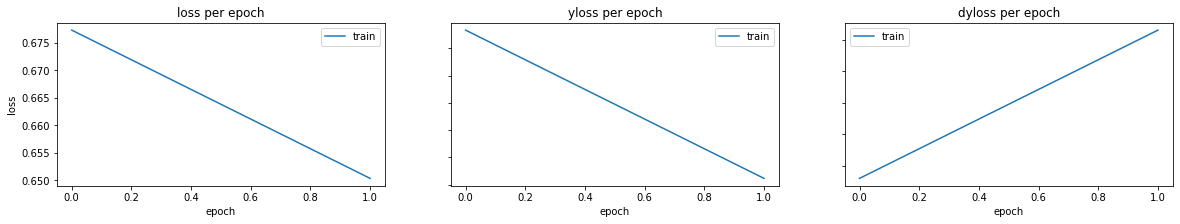

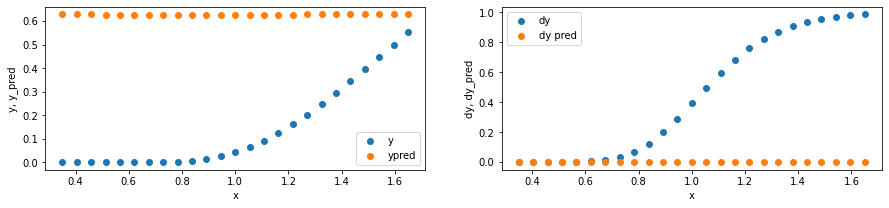

In [46]:
model, test_loss, stats_dic[key1][key2][key3][1] = run_train(
    name = name, 
    generator = generator, 
    with_derivative = with_derivative, 
    model_class = model_class, 
    model_kwargs = mlp_model_kwargs,
    normalize = False, 
    learning_rate_schedule = learning_rate_schedule)

### **4.1.2) normalize = True**

In [47]:
key3 = "normalize"
stats_dic[key1][key2][key3] = [None, None]

Epoch 0: train loss: 2.25970404163003, y loss : 1.2903273755125702, dy loss : 0.969376675705571

train loss no scaled: 1.036626022162527, y loss  no scaled : 0.06724934645695611, dy loss  no scaled: 0.969376675705571


Epoch 1: train loss: 2.2440002664923666, y loss : 1.274070327654481, dy loss : 0.9699298904389434

train loss no scaled: 1.036331948525185, y loss  no scaled : 0.0664020580862416, dy loss  no scaled: 0.9699298904389434






test loss: 1.1239399871230125, y loss : 0.7753304131375626, dydx loss : 0.34860956435932167

test loss no scaled: 0.38901827232821234, y loss  no scaled : 0.040408707968890664, dydx loss  no scaled: 0.34860956435932167




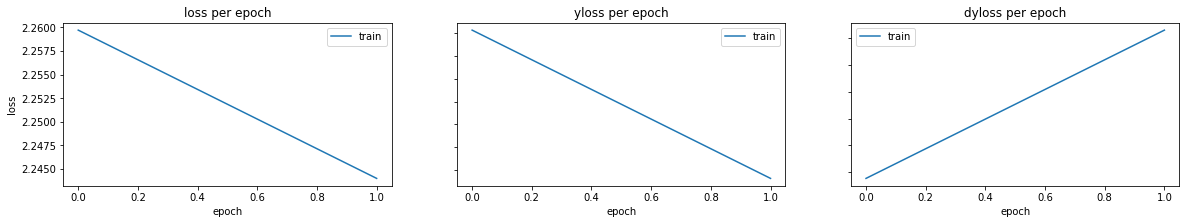

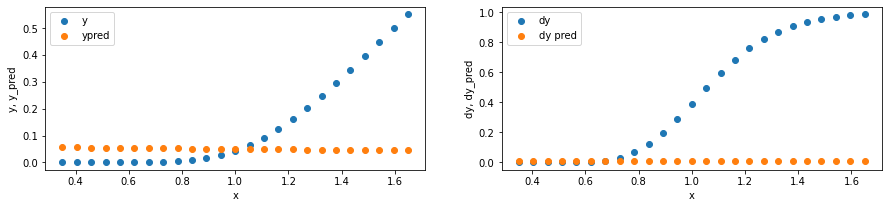

In [48]:
model, test_loss, stats_dic[key1][key2][key3][0] = run_train(
    name = name, 
    generator = generator, 
    with_derivative = with_derivative, 
    model_class = model_class, 
    model_kwargs = mlp_model_kwargs,
    normalize = True, 
    learning_rate_schedule = None)

Epoch 0: train loss: 2.2415069678425787, y loss : 1.253546165432781, dy loss : 0.9879608029867814

train loss no scaled: 1.0532931839379307, y loss  no scaled : 0.06533238095114939, dy loss  no scaled: 0.9879608029867814


Epoch 1: train loss: 2.2250074587017297, y loss : 1.23698210792616, dy loss : 0.9880253294763679

train loss no scaled: 1.0524944263820362, y loss  no scaled : 0.06446909690566827, dy loss  no scaled: 0.9880253294763679






test loss: 1.1080373184382915, y loss : 0.7478588463459164, dydx loss : 0.36017846652277513

test loss no scaled: 0.39915541057584053, y loss  no scaled : 0.03897694405306538, dydx loss  no scaled: 0.36017846652277513




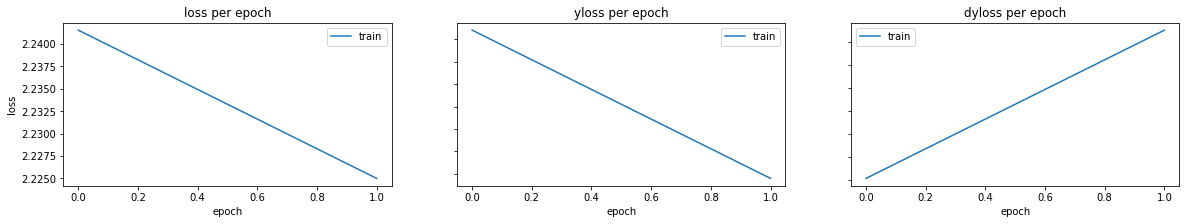

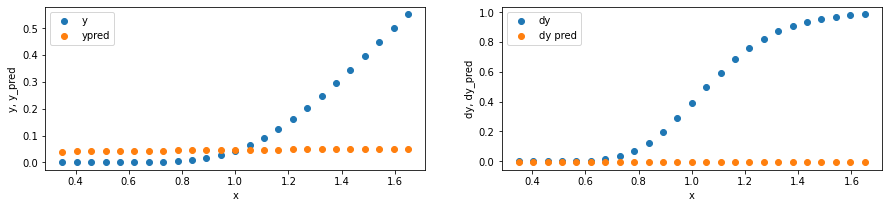

In [49]:
model, test_loss, stats_dic[key1][key2][key3][1] = run_train(
    name = name, 
    generator = generator, 
    with_derivative = with_derivative, 
    model_class = model_class, 
    model_kwargs = mlp_model_kwargs,
    normalize = True, 
    learning_rate_schedule = learning_rate_schedule)

## **4.2) with Siren**

In [50]:
model_class = Siren
key2 = "siren"
stats_dic[key1][key2] = {}

### **4.2.1) normalize = False**

In [51]:
key3 = "no_normalize"
stats_dic[key1][key2][key3] = [None, None]

Epoch 0: train loss: 1.3399006510525941, y loss : 0.06210330261499621, dy loss : 1.2777973394840956

train loss no scaled: 1.3399006420990918, y loss  no scaled : 0.06210330261499621, dy loss  no scaled: 1.2777973394840956


Epoch 1: train loss: 1.4175432609952987, y loss : 0.057514546442907884, dy loss : 1.3600287175551058

train loss no scaled: 1.4175432639980137, y loss  no scaled : 0.057514546442907884, dy loss  no scaled: 1.3600287175551058






test loss: 1.0121283704042434, y loss : 0.03526511423115153, dydx loss : 0.9768632454238833

test loss no scaled: 1.0121283596550348, y loss  no scaled : 0.03526511423115153, dydx loss  no scaled: 0.9768632454238833




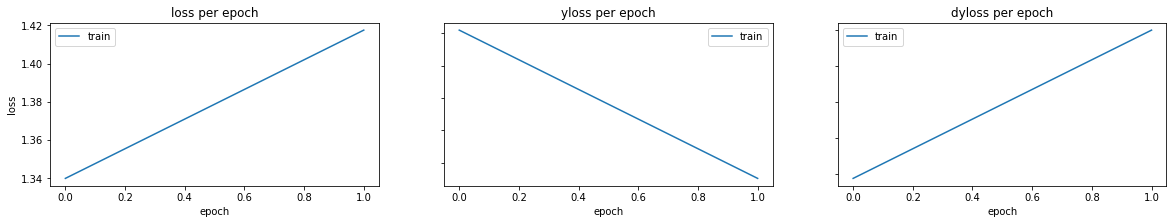

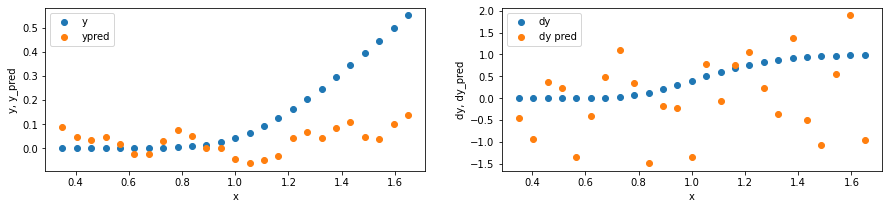

In [52]:
model, test_loss, stats_dic[key1][key2][key3][0] = run_train(
    name = name, 
    generator = generator, 
    with_derivative = with_derivative, 
    model_class = model_class, 
    model_kwargs = siren_model_kwargs,
    normalize = False, 
    learning_rate_schedule = None)

Epoch 0: train loss: 0.8138140666112303, y loss : 0.1012544278963469, dy loss : 0.7125596549082548

train loss no scaled: 0.8138140828046017, y loss  no scaled : 0.1012544278963469, dy loss  no scaled: 0.7125596549082548


Epoch 1: train loss: 0.894685926400125, y loss : 0.09600277910765725, dy loss : 0.7986831543222069

train loss no scaled: 0.8946859334298642, y loss  no scaled : 0.09600277910765725, dy loss  no scaled: 0.7986831543222069






test loss: 1.1946355657000094, y loss : 0.07536967541826016, dydx loss : 1.1192658901878387

test loss no scaled: 1.194635565606099, y loss  no scaled : 0.07536967541826016, dydx loss  no scaled: 1.1192658901878387




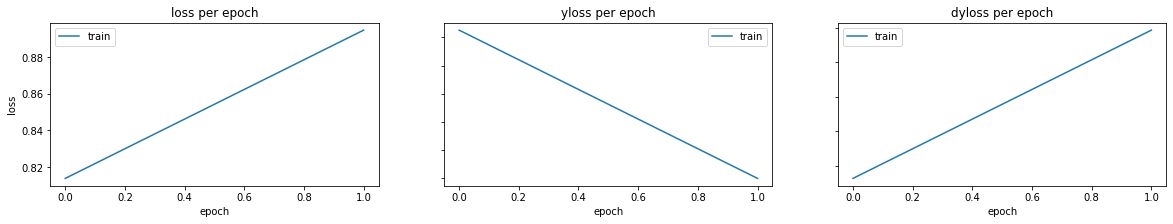

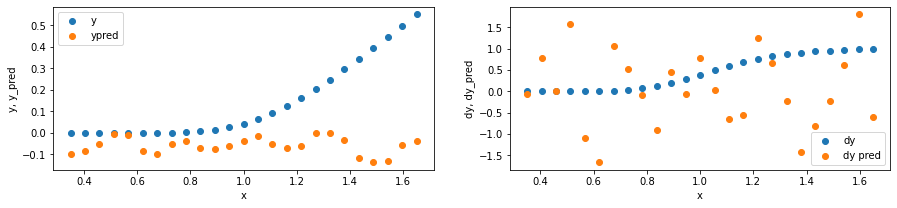

In [53]:
model, test_loss, stats_dic[key1][key2][key3][1] = run_train(
    name = name, 
    generator = generator, 
    with_derivative = with_derivative, 
    model_class = model_class, 
    model_kwargs = siren_model_kwargs,
    normalize = False, 
    learning_rate_schedule = learning_rate_schedule)

### **4.2.2) normalize = True**

In [54]:
key3 = "normalize"
stats_dic[key1][key2][key3] = [None, None]

Epoch 0: train loss: 2.0959376734495163, y loss : 1.0149847576022148, dy loss : 1.0809529087133705

train loss no scaled: 1.1338519332278518, y loss  no scaled : 0.052899024514481426, dy loss  no scaled: 1.0809529087133705


Epoch 1: train loss: 2.0607478857040404, y loss : 1.004846624955535, dy loss : 1.0559012576378881

train loss no scaled: 1.1082719045784324, y loss  no scaled : 0.052370646940544247, dy loss  no scaled: 1.0559012576378881






test loss: 1.325370100736618, y loss : 0.6294539871998132, dydx loss : 0.6959161032456904

test loss no scaled: 0.7287220177636481, y loss  no scaled : 0.03280591451795772, dydx loss  no scaled: 0.6959161032456904




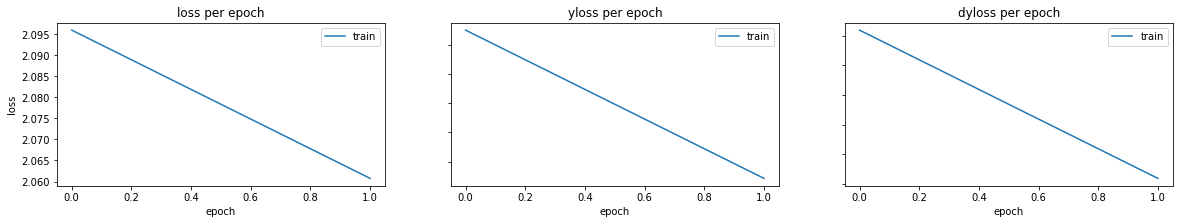

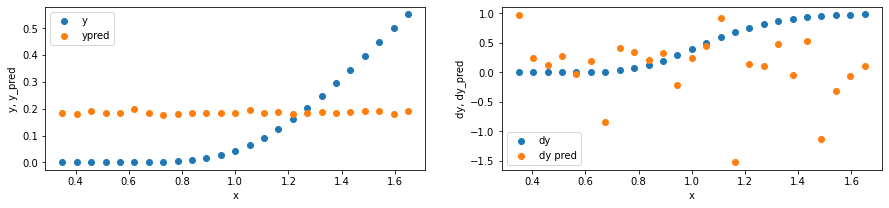

In [55]:
model, test_loss, stats_dic[key1][key2][key3][0] = run_train(
    name = name, 
    generator = generator, 
    with_derivative = with_derivative, 
    model_class = model_class, 
    model_kwargs = siren_model_kwargs,
    normalize = True, 
    learning_rate_schedule = None)

Epoch 0: train loss: 2.190560808125883, y loss : 1.0165862902672962, dy loss : 1.1739745286665857

train loss no scaled: 1.2269570215253043, y loss  no scaled : 0.052982492858718616, dy loss  no scaled: 1.1739745286665857


Epoch 1: train loss: 2.1386165883764625, y loss : 1.0054227457381786, dy loss : 1.1331938403268578

train loss no scaled: 1.1855945120703837, y loss  no scaled : 0.05240067174352589, dy loss  no scaled: 1.1331938403268578






test loss: 1.1863245499879123, y loss : 0.5998713903315366, dydx loss : 0.5864531611790881

test loss no scaled: 0.6177172894700198, y loss  no scaled : 0.0312641282909317, dydx loss  no scaled: 0.5864531611790881




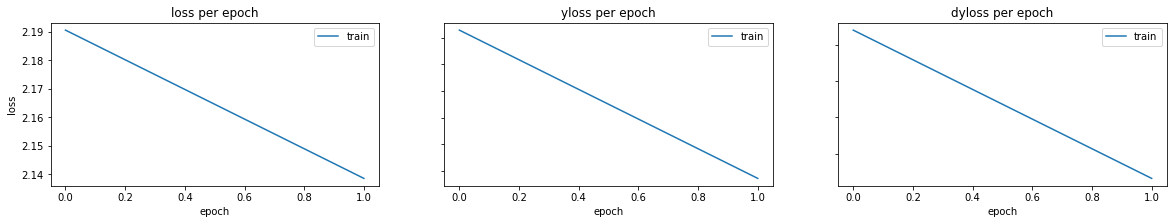

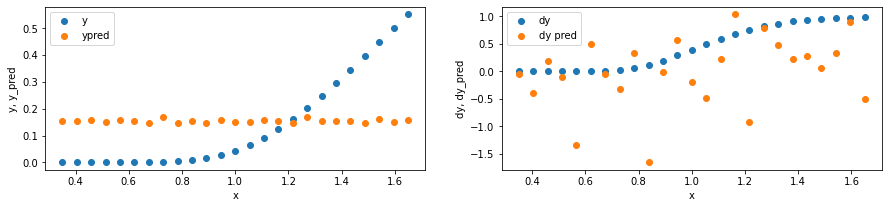

In [56]:
model, test_loss, stats_dic[key1][key2][key3][1] = run_train(
    name = name, 
    generator = generator, 
    with_derivative = with_derivative, 
    model_class = model_class, 
    model_kwargs = siren_model_kwargs,
    normalize = True, 
    learning_rate_schedule = learning_rate_schedule)

# **5) Global Stats**

In [57]:
global_stat(stats_dic, suptitle = graph_name)

{'normal_training': {'mlp': {'no_normalize': [{'train_loss': [0.33458205938339236, 0.3031326761841774]}, {'train_loss': [0.21117836143999738, 0.19169505072990434]}], 'normalize': [{'train_loss': [1.11059097468853, 1.1031827810406685]}, {'train_loss': [1.313491124017164, 1.2943011300452054]}]}, 'siren': {'no_normalize': [{'train_loss': [0.06585207189185895, 0.06310642761835879]}, {'train_loss': [0.0506098364686477, 0.047409993122422875]}], 'normalize': [{'train_loss': [0.997600126452744, 0.9885951699689031]}, {'train_loss': [1.0208095971122384, 1.0132266207039355]}]}}, 'sobolev_training': {'mlp': {'no_normalize': [{'train_loss': [0.5948491236567497, 0.5736982741951943], 'train_yloss': [0.23572960495948792, 0.2151367749273777], 'train_dyloss': [0.35911951601970943, 0.35856149590923453]}, {'train_loss': [0.42640052502043546, 0.423443308910355], 'train_yloss': [0.0634755763420253, 0.06072650665684705], 'train_dyloss': [0.362924948023865, 0.3627168050361797]}], 'normalize': [{'train_loss': 